# Classifier based on a combination of neural models

Intent classification system based on a combination of neural models for the restaurant information search.


## Required libraries

In [ ]:
# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

# NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# SKlearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics

# NumPy
import numpy as np

# Standard
import pickle

## Paths

The datasets and dictionaries used in this notebook can be downloaded from this [link](https://drive.google.com/drive/folders/178Sv30P-OvoJc_QOOAYkmUHgcQsPg-rb?usp=sharing). Also, it will be necessary to change the path of the `dataset_path` variable to the path wherein the downloaded information is saved. 

**Notes:** 

* The downloaded data can be obtained using the *TextAnalysis_DSTC2.ipynb* notebook.
* Only a UC3M user can access to the download link.

In [ ]:
dataset_path = "/content/drive/My Drive/_TFM/Notebooks/Datasets/"
glove_path = "/content/drive/My Drive/_TFM/Notebooks/Models/glove/glove.6B.100d.txt"
neural_path = "/content/drive/My Drive/_TFM/Notebooks/Models/neural/"

# Download some tools for the NLTK library
nltk.download("wordnet")
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Data reading


DSTC 2 dataset provides dialogues of a human talking to a information system labelled with slots and dialogue actions.

In our case, the labels will be the users' intents which are the combination of acts and slots.

The data only has information about users' utterances.

**Load dataset**

In [ ]:
# x_train
x_train_obj = open(dataset_path + "x_train.obj", "rb")
x_train = pickle.load(x_train_obj)
x_train_obj.close()

# y_train
y_train_obj = open(dataset_path + "y_train.obj", "rb")
y_train = pickle.load(y_train_obj)
y_train_obj.close()

# x_valid
x_valid_obj = open(dataset_path + "x_valid.obj", "rb")
x_valid = pickle.load(x_valid_obj)
x_valid_obj.close()

# y_valid
y_valid_obj = open(dataset_path + "y_valid.obj", "rb")
y_valid = pickle.load(y_valid_obj)
y_valid_obj.close()

# x_test
x_test_obj = open(dataset_path + "x_test.obj", "rb")
x_test = pickle.load(x_test_obj)
x_test_obj.close()

# y_test
y_test_obj = open(dataset_path + "y_test.obj", "rb")
y_test = pickle.load(y_test_obj)
y_test_obj.close()

**Check data**

In [ ]:
print("Data = (X: users' utterances, y: intents)")

print("\n  > Train data:")
print("Samples: 8148 = %s" % len(x_train))
print(list(zip(x_train, y_train))[:3])

print("\n  > Validation data:")
print("Samples: 5656 = %s" % len(x_valid))
print(list(zip(x_valid, y_valid))[:3])

print("\n  > Test data:")
print("Samples: 5769 = %s" % len(x_test))
print(list(zip(x_test, y_test))[:3])

Data = (X: users' utterances, y: intents)

  > Train data:
Samples: 8148 = 8148
[('cheap restaurant', ['inform_pricerange']), ('any', ['inform_this']), ('south', ['inform_area'])]

  > Validation data:
Samples: 5656 = 5656
[('sil', ['unknown']), ('north part of town serving gastropub food', ['inform_food', 'inform_area']), ('north part of town serving gastropub food', ['inform_food', 'inform_area'])]

  > Test data:
Samples: 5769 = 5769
[('uh yes im looking for a cheap restaurant in the west part of town', ['affirm', 'inform_pricerange', 'inform_area']), ('west', ['inform_area']), ('uh yes a cheap restaurant', ['affirm', 'inform_pricerange'])]


## Data preprocessing


Each text sample will follow the next pipeline:

*raw text* > **decontraction** > **normalization** > **lemmatization** > **lowercasing** > **tokenization** > **padding** > *tokens*

And then, we will build the vocabulary including the UNK token. The PAD token will be zero.

**Settings**

In [ ]:
# We limit the sequence length to 18 words
maxlen = 18

# Considerer only the most frequent 550 words
max_words = 550

# Merge all samples
x_data = np.concatenate([x_train, x_valid, x_test])

In [ ]:
# Decontract funtion
contracted_words_obj = open(dataset_path + "contracted_words.obj", "rb")
contracted_words = pickle.load(contracted_words_obj)
contracted_words_obj.close()

def decontract(text):
  for word in text.split():
    if word.lower() in contracted_words:
      text = text.replace(word, contracted_words[word.lower()])
  return text

# Normalize function
normalized_words_obj = open(dataset_path + "normalized_words.obj", "rb")
normalized_words = pickle.load(normalized_words_obj)
normalized_words_obj.close()

def normalize(text):
  for word in text.split():
    if word.lower() in normalized_words:
      text = text.replace(word, normalized_words[word.lower()])
  return text

In [ ]:
# Lemmatize function

# Set the lemmatizer
lemmatizer = WordNetLemmatizer()

# Get the POS tag for a given word
def get_pos_tag(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

# Lemmatize a text with POS tag
def lemmatize(text, lemmatizer):
  word_list = nltk.word_tokenize(text)
  text_lemmatized = ' '.join([lemmatizer.lemmatize(word, get_pos_tag(word)) for word in word_list])
  return text_lemmatized

**Preprocessing**

In [ ]:
# Decontract, normalize, lemmatize, lowercase and tokenize text samples
tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token="unk")
tokenizer.fit_on_texts(
    [lemmatize(normalize(decontract(sample)), lemmatizer) for sample in x_data])

x_train_prepro = tokenizer.texts_to_sequences(
    [lemmatize(normalize(decontract(sample)), lemmatizer) for sample in x_train])
x_valid_prepro = tokenizer.texts_to_sequences(
    [lemmatize(normalize(decontract(sample)), lemmatizer) for sample in x_valid])
x_test_prepro = tokenizer.texts_to_sequences( 
    [lemmatize(normalize(decontract(sample)), lemmatizer) for sample in x_test])

# Padding
x_train_prepro = pad_sequences(x_train_prepro,  maxlen=maxlen, padding="post")
x_valid_prepro = pad_sequences(x_valid_prepro,  maxlen=maxlen, padding="post")
x_test_prepro = pad_sequences(x_test_prepro,  maxlen=maxlen, padding="post")

# Vocabulary
x_vocab = tokenizer.word_index
x_vocab_size = min(max_words, len(x_vocab) + 1)

In [ ]:
x_vocab_size

502

## Featurization


### GloVe embedding

We use [GloVe](https://nlp.stanford.edu/projects/glove/) embedder that is an unsupervised learning algorithm for obtaining vector representations for words.

In our case, we select 100-dimensional GloVe embeddings of 400k words computed on a 2014 dump of English Wikipedia.

**Parsing the GloVe word-embeddings file**

In [ ]:
embeddings_index = {}
 
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        embed = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = embed

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


**Preparing the GloVe word-embeddings matrix**

In [ ]:
embedding_dim = 100

# Words not found in the embedding index will be all zeros
embedding_matrix = np.zeros((max_words, embedding_dim), dtype="float32")
 
for word, i in x_vocab.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Labels (Multi-Label Binarizer)

On the other hand, the labels will be encoded as *n* binary elements in an array, where *n* is the total number of labels.

The binary vector (associated to each sample) indicates the presence of labels.

In [ ]:
# Load the labels
labels_obj = open(dataset_path + "labels.obj", "rb")
labels = pickle.load(labels_obj)
labels_obj.close()

In [ ]:
# Build the multi-label binarizer
mlb = MultiLabelBinarizer(classes=labels)

# Binarize the datasets
y_train_mlb = mlb.fit_transform(y_train)
y_valid_mlb = mlb.fit_transform(y_valid)
y_test_mlb = mlb.fit_transform(y_test)

## Neural model

In [ ]:
# Model name based on the feature layer (embed/glove)
model_name = "neural_model_glove"

### Network definition

The model is defined using the Keras functional API.

In [ ]:
input = Input(shape=(maxlen,))

# Word embedding layer
#x = Embedding(max_words, 128)(input)

# Glove embedding layer
x = Embedding(max_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input)

x = Bidirectional(LSTM(256, return_sequences=True))(x)

x = Conv1D(128, kernel_size=5, padding="same")(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

x = concatenate([avg_pool, max_pool])

output = Dense(len(labels), activation="sigmoid")(x)
 
model = Model(input, output)
 
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 18, 100)      55000       input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 18, 512)      731136      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 18, 128)      327808      bidirectional_1[0][0]            
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.1), loss="binary_crossentropy", metrics=["accuracy"])

Architecture of the neural network:

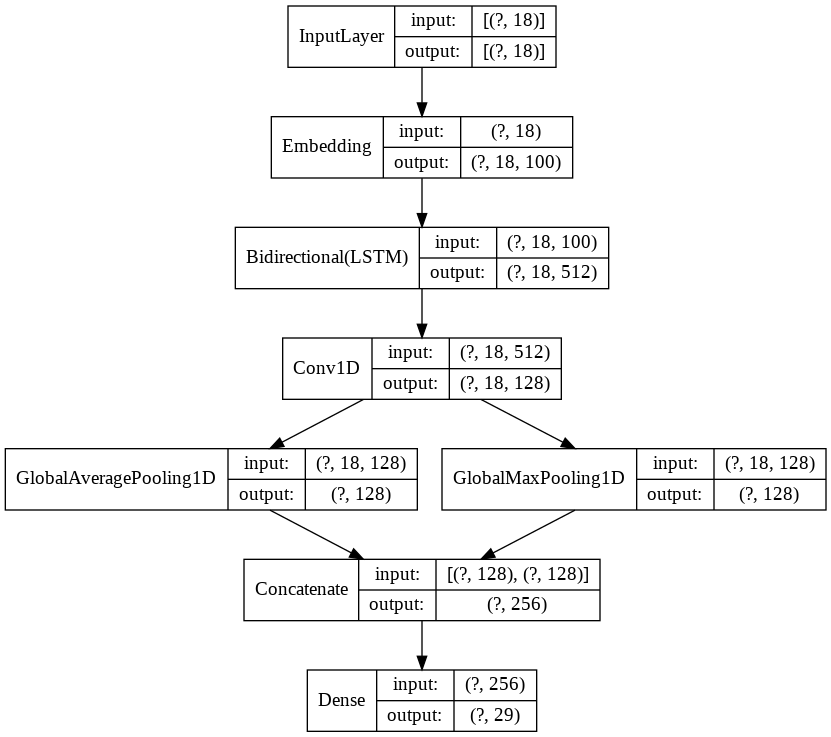

In [ ]:
plot_path = neural_path + model_name + ".png"

plot_model(model, to_file=plot_path, show_shapes=True, show_layer_names=False)

###Training & validation

In [ ]:
epochs = 50
batch_size = 128

callbacks_list = [
  # Interrupts training when improvements stops
  EarlyStopping(monitor="val_loss", patience=5),
  # Save the best model
  ModelCheckpoint(filepath=neural_path + model_name + ".h5",
                  monitor="val_loss",
                  save_best_only=True)
]

model.fit(x_train_prepro, y_train_mlb,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(x_valid_prepro, y_valid_mlb),
          callbacks=callbacks_list,
          verbose=1)

Epoch 1/50
64/64 [==============================] - 2s 33ms/step - loss: 0.1035 - accuracy: 0.8519 - val_loss: 0.3202 - val_accuracy: 0.8525
Epoch 2/50
64/64 [==============================] - 2s 32ms/step - loss: 0.1186 - accuracy: 0.8382 - val_loss: 0.2666 - val_accuracy: 0.8214
Epoch 3/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0743 - accuracy: 0.8096 - val_loss: 0.2449 - val_accuracy: 0.8382
Epoch 4/50
64/64 [==============================] - 2s 32ms/step - loss: 0.0775 - accuracy: 0.8057 - val_loss: 0.3655 - val_accuracy: 0.8393
Epoch 5/50
64/64 [==============================] - 2s 31ms/step - loss: 0.0797 - accuracy: 0.7802 - val_loss: 0.2399 - val_accuracy: 0.8126
Epoch 6/50
64/64 [==============================] - 2s 30ms/step - loss: 0.0766 - accuracy: 0.7812 - val_loss: 0.3078 - val_accuracy: 0.7930
Epoch 7/50
64/64 [==============================] - 2s 30ms/step - loss: 0.1173 - accuracy: 0.7988 - val_loss: 0.2977 - val_accuracy: 0.8289
Epoch 8/50
64

### Evaluation

In [ ]:
# Map a probability vector into a binary vector given a confident threshold
def probab2mlb(probab, threshold):
  mlb = np.zeros(np.shape(probab), dtype=int)
  for index in range(len(probab)):
    mlb[index, list(np.where(np.array(probab[index]) > threshold)[0])] = 1
  return mlb

#### Embedding layer

In [ ]:
model_name = "neural_model_embed"

neural_model_embed = load_model(neural_path + model_name + ".h5")

**Accuracy**

In [ ]:
print("Accuracy: %s" % round(neural_model_embed.evaluate(x_test_prepro, y_test_mlb, verbose=1)[1], 4))

181/181 [==============================] - 2s 9ms/step - loss: 6.6729 - accuracy: 0.8908
Accuracy: 0.8908


**Precision, Recall & F1-Score**

In [ ]:
# Predicted probability vector
y_test_prob_pred = neural_model_embed.predict(x_test_prepro)

# Predicted binary vector
y_test_mlb_pred = probab2mlb(y_test_prob_pred, threshold=0.5)

In [ ]:
print(metrics.classification_report(y_test_mlb, y_test_mlb_pred, target_names=labels, zero_division=0))

                    precision    recall  f1-score   support

               ack       0.75      0.43      0.55         7
            affirm       1.00      0.95      0.97       326
               bye       0.99      1.00      1.00       619
      confirm_area       0.40      1.00      0.57         2
      confirm_food       0.79      0.92      0.85        25
confirm_pricerange       0.88      1.00      0.93         7
         deny_food       0.00      0.00      0.00         2
         deny_name       0.00      0.00      0.00         0
             hello       0.85      1.00      0.92        28
       inform_area       0.98      0.98      0.98       653
       inform_food       0.96      0.97      0.96      1439
       inform_name       0.00      0.00      0.00        15
 inform_pricerange       0.99      0.99      0.99       526
       inform_this       0.98      0.99      0.98       537
            negate       0.97      0.91      0.94        69
            repeat       1.00      0.26

#### GloVe embedding

In [ ]:
model_name = "neural_model_glove"

neural_model_glove = load_model(neural_path + model_name + ".h5")

**Accuracy**

In [ ]:
print("Accuracy: %s" % round(neural_model_glove.evaluate(x_test_prepro, y_test_mlb, verbose=1)[1], 4))

181/181 [==============================] - 2s 9ms/step - loss: 0.2734 - accuracy: 0.8175
Accuracy: 0.8175


**Precision, Recall & F1-Score**

In [ ]:
# Predicted probability vector
y_test_prob_pred = neural_model_glove.predict(x_test_prepro)

# Predicted binary vector
y_test_mlb_pred = probab2mlb(y_test_prob_pred, threshold=0.5)

In [ ]:
print(metrics.classification_report(y_test_mlb, y_test_mlb_pred, target_names=labels, zero_division=0))

                    precision    recall  f1-score   support

               ack       1.00      0.43      0.60         7
            affirm       1.00      0.80      0.89       326
               bye       0.98      1.00      0.99       619
      confirm_area       0.67      1.00      0.80         2
      confirm_food       1.00      0.60      0.75        25
confirm_pricerange       1.00      0.86      0.92         7
         deny_food       0.00      0.00      0.00         2
         deny_name       0.00      0.00      0.00         0
             hello       0.96      0.93      0.95        28
       inform_area       0.95      0.99      0.97       653
       inform_food       0.96      0.96      0.96      1439
       inform_name       0.00      0.00      0.00        15
 inform_pricerange       0.97      0.98      0.98       526
       inform_this       1.00      0.97      0.98       537
            negate       1.00      0.77      0.87        69
            repeat       1.00      0.26

### Predictions

In [ ]:
# Model name based on the feature layer (embed/glove)
model_name = "neural_model_embed"

We inspect some predictions.

In [ ]:
neural_model = load_model(neural_path + model_name + ".h5")

In [ ]:
# Predicted probability vector
y_test_prob_pred = neural_model.predict(x_test_prepro)

# Predicted binary vector
y_test_mlb_pred = probab2mlb(y_test_prob_pred, threshold=0.5)

# Predicted labels
y_test_pred = mlb.inverse_transform(y_test_mlb_pred)

In [ ]:
index_sample = 0

print("User's utterance: %s" % x_test[index_sample])

print("\nTrue label: %s" % y_test[index_sample])
print("Predicted label: %s" % list(y_test_pred[index_sample]))

print("\nTrue binary label: %s" % y_test_mlb[index_sample])
print("Predicted binary label: %s" % y_test_mlb_pred[index_sample])

print("\nPredicted prob label: %s" % y_test_prob_pred[index_sample])

User's utterance: uh yes im looking for a cheap restaurant in the west part of town

True label: ['affirm', 'inform_pricerange', 'inform_area']
Predicted label: ['affirm', 'inform_area', 'inform_pricerange']

True binary label: [0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted binary label: [0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Predicted prob label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
